# (04) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 3
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:3  ———  host: mach

## MNIST:

- CONV decoder
- k = 128
- dec starting spat_dim = 2
- $(T, \beta) = (8, 4.0)$

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jacob|conv')

seq_len = 16
cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len
cfg_vae['n_latents'] = 128

cfg_tr['kl_beta'] = 3/8 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [5]:
tr.n_iters

120000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  1.4 Mil   |
|     ———     |    ———     |
|    layer    |  1.4 Mil   |
+-------------+------------+

poisson_MNIST_t-16_z-[128]_k-32_<jacob|conv>
b200-ep400-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_17,09:34)

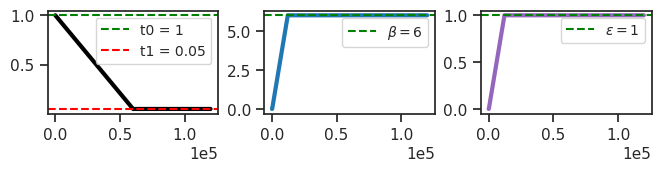

In [6]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [7]:
tr.n_iters

120000

In [8]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  1.4 Mil   |
|     ———      |    ———     |
|    fc_dec    |  132.1 K   |
|     dec      |  1.2 Mil   |
+--------------+------------+

### Fit model

In [9]:
tr.train()

epoch # 400, avg loss: 11.754415: 100%|███| 400/400 [22:03:10<00:00, 198.48s/it]


In [10]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

u_max.max(), du_max.max()

(6.351524353027344, 6.978548049926758)

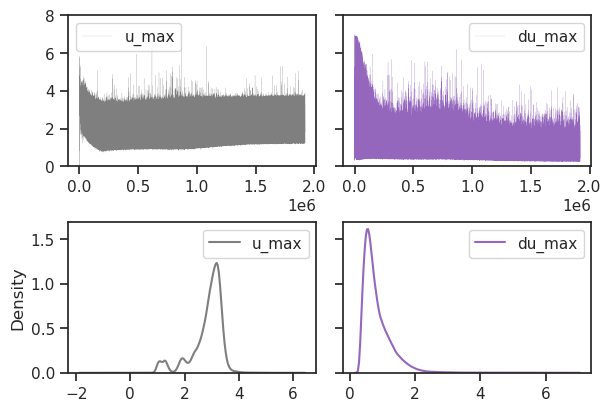

In [11]:
fig, axes = create_figure(2, 2, sharey='row')

axes[0, 0].plot(u_max, color='C7', lw=0.1, label='u_max')
axes[0, 1].plot(du_max, color='C4', lw=0.1, label='du_max')
axes[0, 1].set(ylim=(0, 8))

sns.kdeplot(u_max, color='C7', label='u_max', ax=axes[1, 0])
sns.kdeplot(du_max, color='C4', label='du_max', ax=axes[1, 1])

add_legend(axes)
plt.show()

In [12]:
grad = np.array(list(tr.stats['grad'].values()))
(grad > tr.cfg.grad_clip).sum(), np.round((grad > tr.cfg.grad_clip).mean(), 3)

(1168, 0.01)

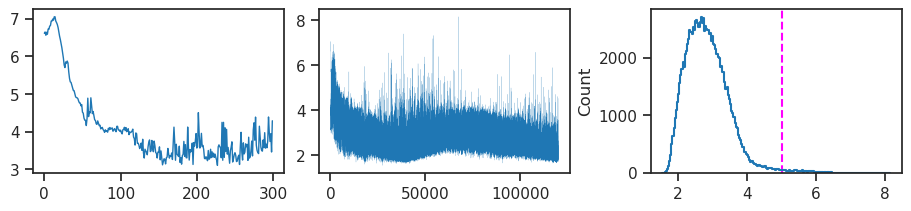

In [13]:
fig, axes = create_figure(1, 3)

axes[0].plot(np.log(grad)[:300], lw=1)
axes[1].plot(np.log(grad), lw=0.1)

axes[2].axvline(np.log(tr.cfg.grad_clip), color='magenta', ls='--')
histplot(np.log(grad), ax=axes[2])

plt.show()

### Load model

In [11]:
# model_name = 'poisson_uniform_c(-2)_MNIST_t-8_z-[32]_k-32_<jacob|conv+b>'
# fit_name = 'b200-ep500-lr(0.002)_beta(8:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_06,23:11)'
# tr, meta = load_model(model_name, fit_name, device=device)
# meta['checkpoint']

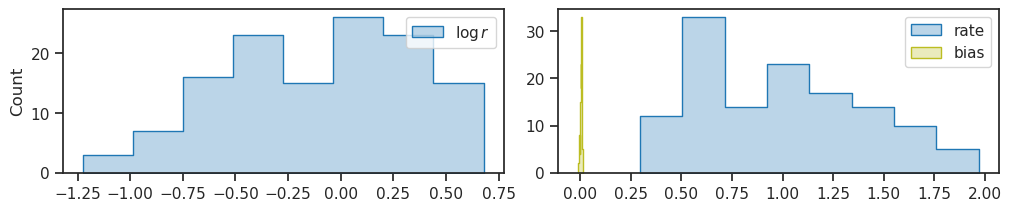

In [14]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=1, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=1, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [15]:
dead = log_rate > 2
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 128, 0.0)

100%|██████████████████████████████| 50/50 [3:34:56<00:00, 257.93s/it]


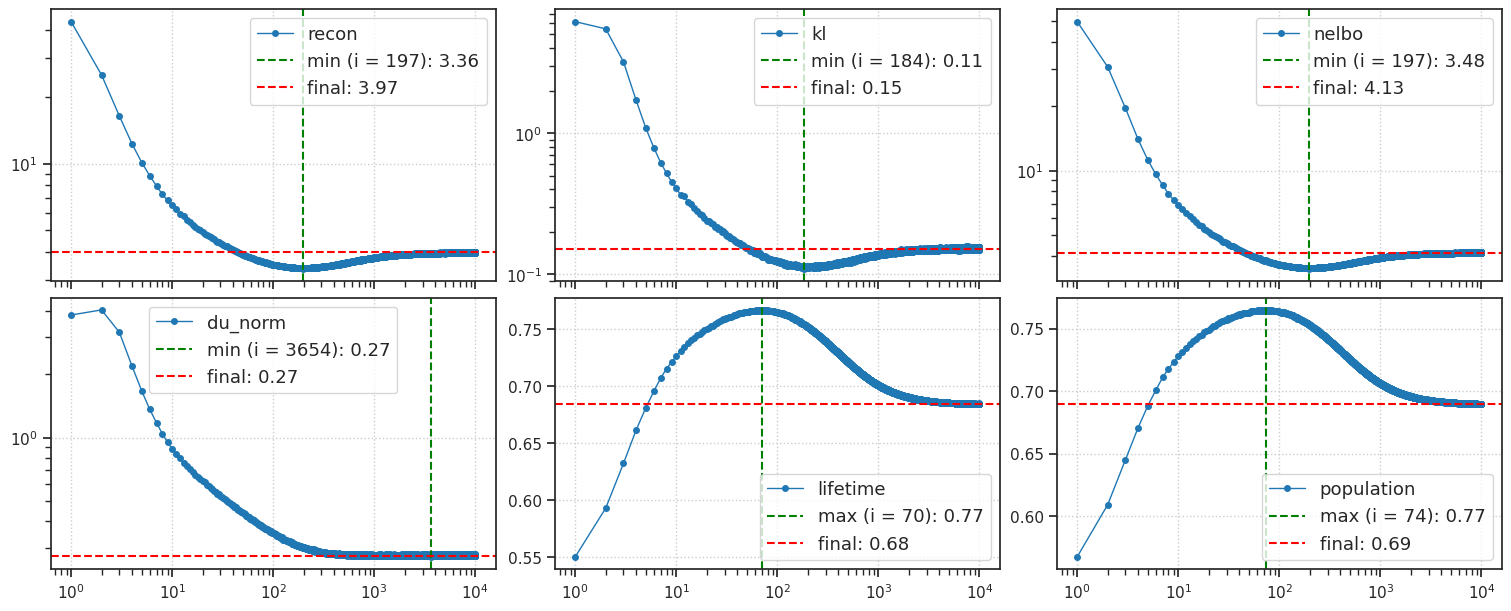

CPU times: user 3h 33min 4s, sys: 1min 14s, total: 3h 34min 18s
Wall time: 3h 35min 16s


In [21]:
%%time

kws = dict(
    seq_total=10000,
    seq_batch_sz=100,
    n_data_batches=None,
    # active=~dead,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='C0')

In [22]:
kws = dict(
    seq_total=tr.model.cfg.seq_len,
    seq_batch_sz=100,
    n_data_batches=1,
    # active=~dead,
    return_recon=True,
    full_data=True,
    verbose=False,
)
results_to_plot = {
    name: tr.analysis(dl=name, **kws)
    for name in ['trn', 'vld']
}

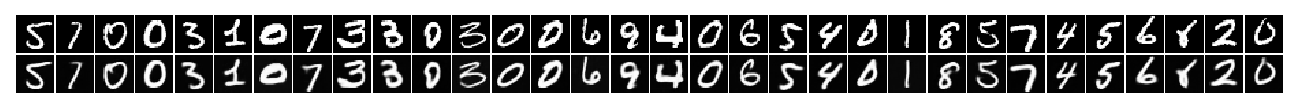

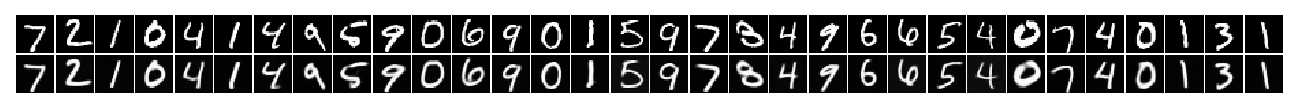

In [24]:
num = 32

x2p_dict = {}
for name, d in results_to_plot.items():
    x2p = np.concatenate([
        d['x'][:num],
        d['y'][:num, -1].reshape(-1, *tr.model.cfg.input_sz),
    ])
    # x2p = (x2p + 1) / 2
    # x2p = np.clip(x2p, 0, 1)
    # x2p_dict[name] = x2p
    _ = plot_weights(x2p, nrows=2)

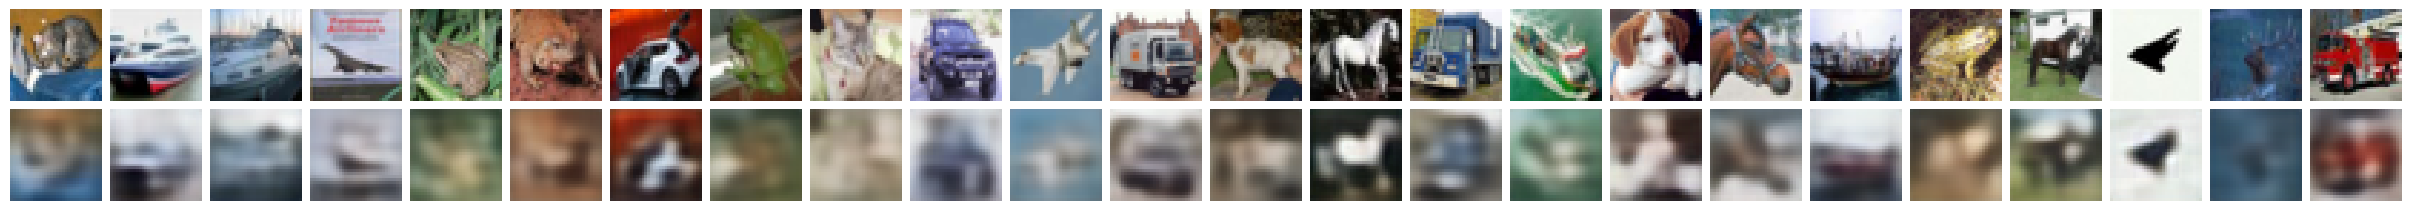

In [22]:
name = 'vld'

fig, axes = create_figure(2, 24, (24, 2))
for i in range(24):
    axes[0, i].imshow(x2p_dict[name][i].transpose(1, 2, 0))
    axes[1, i].imshow(x2p_dict[name][i + 32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

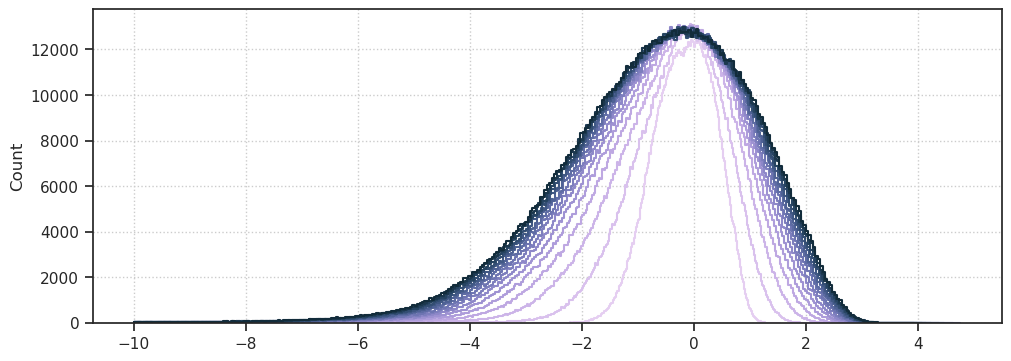

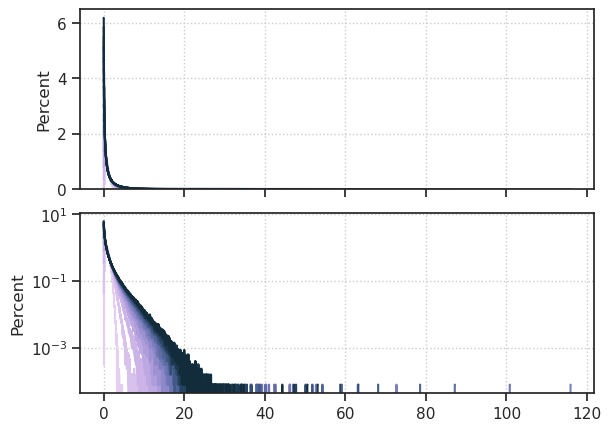

In [25]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    x2p = v[:, ~dead].ravel()
    x2p = x2p[x2p > -10]
    histplot(
        x2p,
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

## TODO:

- apply rotation

- compute MSE

In [88]:
from torchvision.transforms.functional import rotate
from torchvision.transforms.functional import InterpolationMode

In [89]:
model_name = 'gaussian_MNIST_t-1_z-[128]_<mlp|mlp>'
fit_name = 'amort_u:(5.0)-du:(5.0)_b200-ep500-lr(0.002)_beta(1:0x0.1)_gr(100)_(2024_09_11,22:35)'
tr, meta = load_model(model_name, fit_name, device=device, shuffle=False)

In [90]:
x_rot = collections.defaultdict(list)
for theta in tqdm(range(0, 360, 15)):
    for x, *_ in iter(tr.dl_trn):
        x_rot[theta].append(rotate(
            img=x,
            angle=theta,
            interpolation=InterpolationMode.BILINEAR,
        ))
# x_rot = {theta: torch.cat(x) for theta, x in x_rot.items()}

100%|███████████████████████████████████████████| 24/24 [00:11<00:00,  2.01it/s]


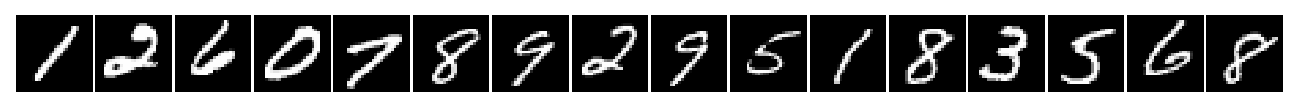

0

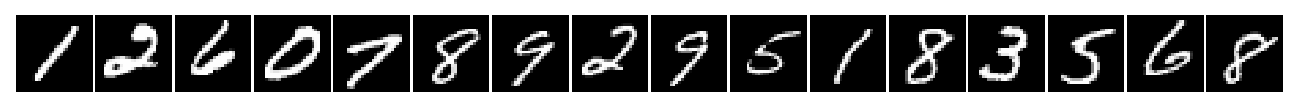

15

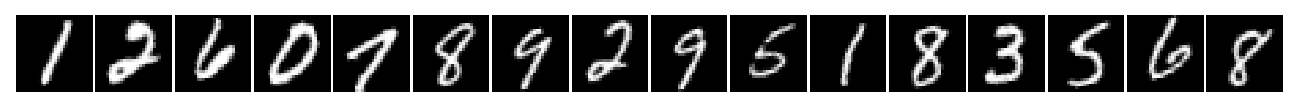

30

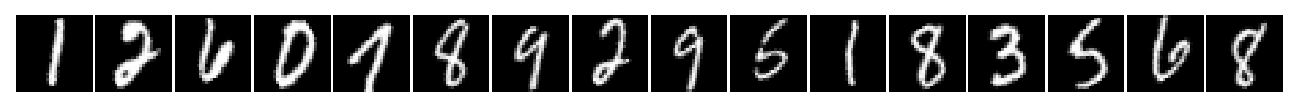

45

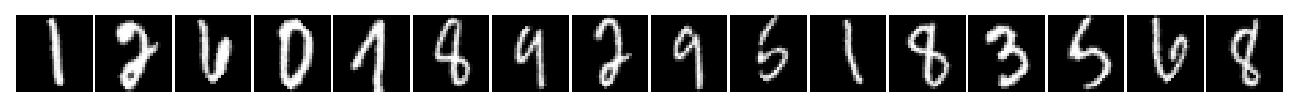

60

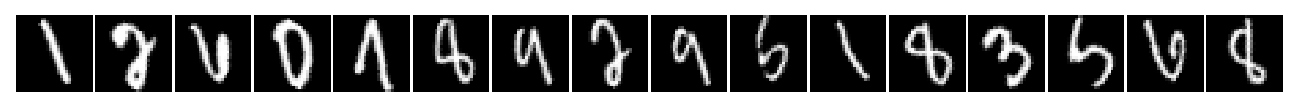

75

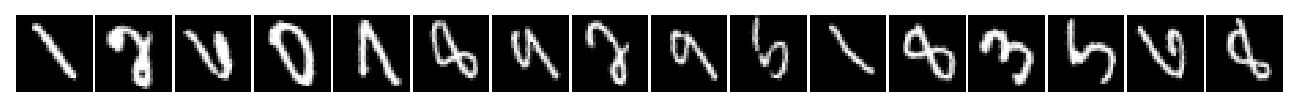

90

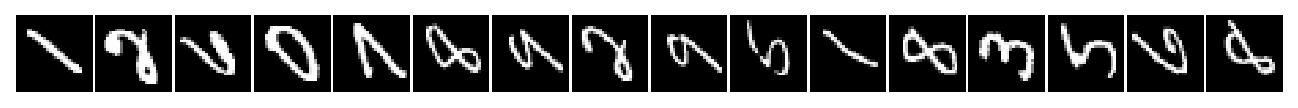

105

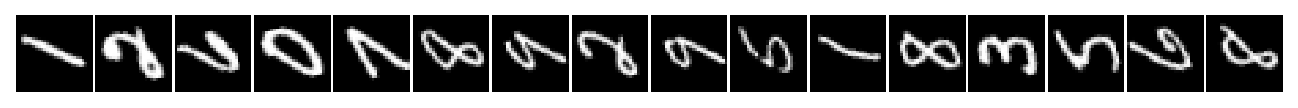

120

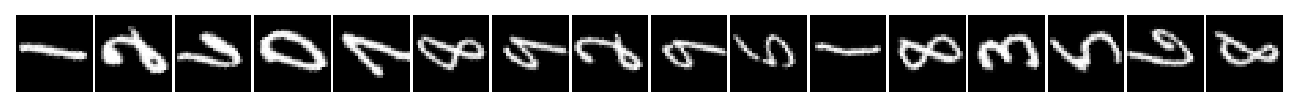

135

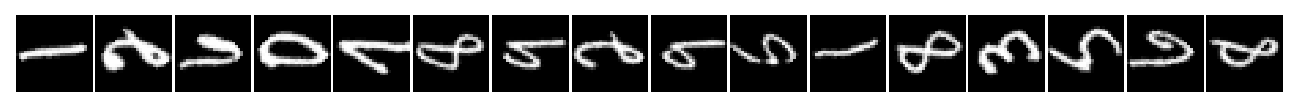

150

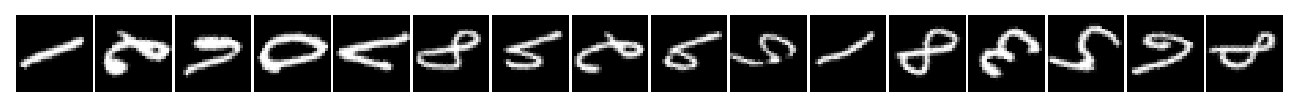

165

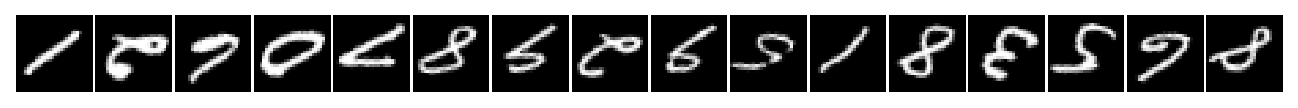

180

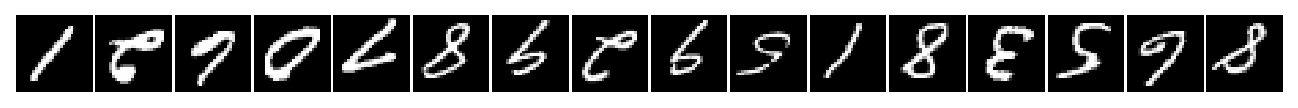

195

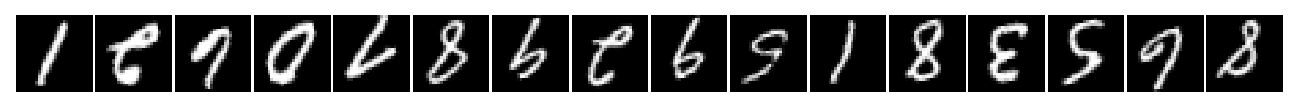

210

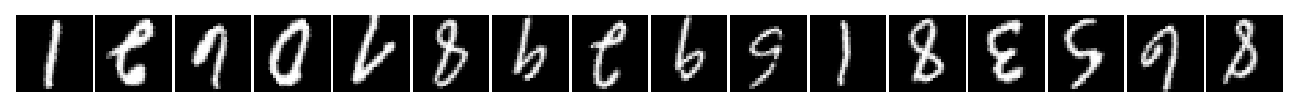

225

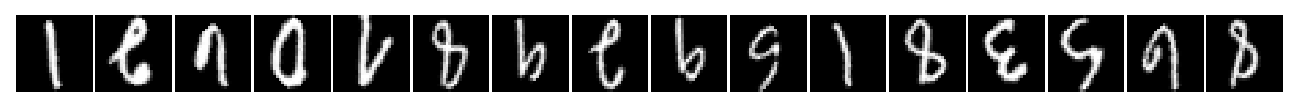

240

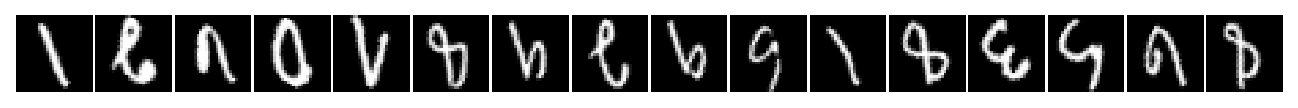

255

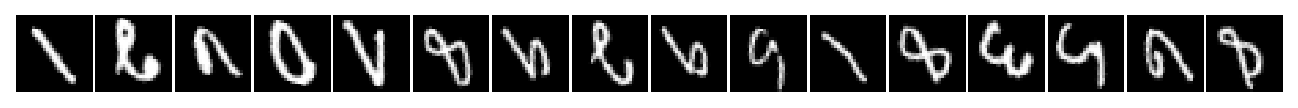

270

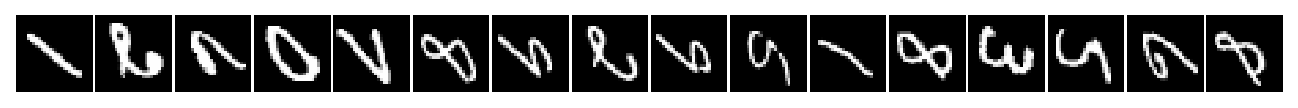

285

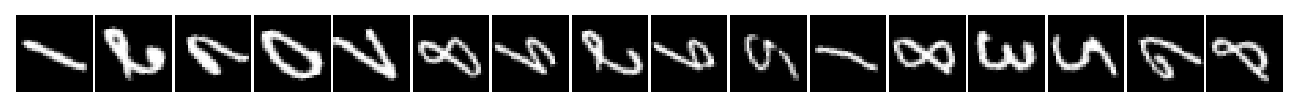

300

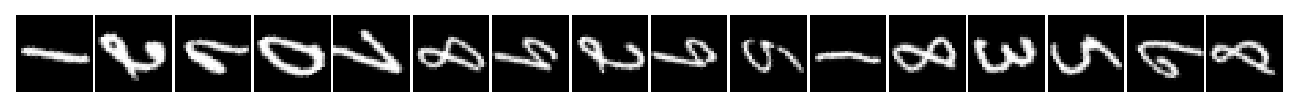

315

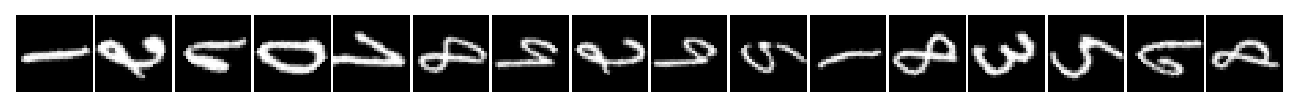

330

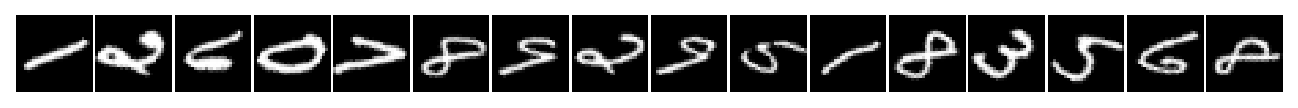

345

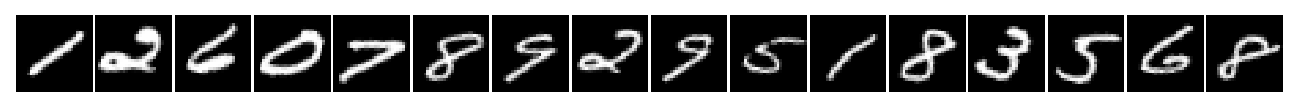

In [92]:
plot_weights(tonp(x[-16:, 0]), nrows=1)
for theta in x_rot:
    print(theta)
    plot_weights(tonp(x_rot[theta][-1][-16:, 0]), nrows=1)

In [114]:
x_rot_trn = collections.defaultdict(list)
z_rot_trn = collections.defaultdict(list)

for theta in tqdm(range(0, 360, 15)):
    for x, *_ in iter(tr.dl_trn):
        _x = rotate(
            img=x,
            angle=theta,
            interpolation=InterpolationMode.BILINEAR,
        )
        output = tr.model.xtract_ftr(_x).stack()
        _z, _ = torch.chunk(tr.model.state, 2, 1)

        x_rot_trn[theta].append(_x)
        z_rot_trn[theta].append(_z)

100%|███████████████████████████████████████████| 24/24 [00:19<00:00,  1.25it/s]


In [115]:
list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [ ]:
output['loss_recon'].shape

In [105]:
aaa = torch.cat([output['dist']['0'].loc, torch.log(output['dist']['0'].scale)], dim=1)
aaa

tensor([[ 2.5400, -0.0181, -2.5723,  ..., -0.6318, -0.6335, -0.6279],
        [ 2.5396, -0.0169, -2.5719,  ..., -0.6320, -0.6332, -0.6279],
        [ 2.5400, -0.0151, -2.5723,  ..., -0.6321, -0.6337, -0.6281],
        ...,
        [ 2.5401, -0.0176, -2.5724,  ..., -0.6321, -0.6337, -0.6279],
        [ 2.5376, -0.0124, -2.5697,  ..., -0.6322, -0.6329, -0.6280],
        [ 2.5398, -0.0137, -2.5720,  ..., -0.6319, -0.6336, -0.6281]],
       device='cuda:3', grad_fn=<CatBackward0>)

In [108]:
torch.dist(tr.model.state, aaa)

tensor(7.2830e-06, device='cuda:3', grad_fn=<DistBackward0>)

In [20]:
%%time

kws = dict(
    seq_total=1,
    seq_batch_sz=1,
    n_data_batches=1,
    active=~dead,
    full_data=True,
    return_recon=True,
)
results_to_plot = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['trn', 'vld'] # , 'tst']
}

100%|███████████████████████████████████| 1/1 [00:00<00:00, 48.80it/s]

CPU times: user 4.79 s, sys: 228 ms, total: 5.01 s
Wall time: 81.5 ms


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

trn

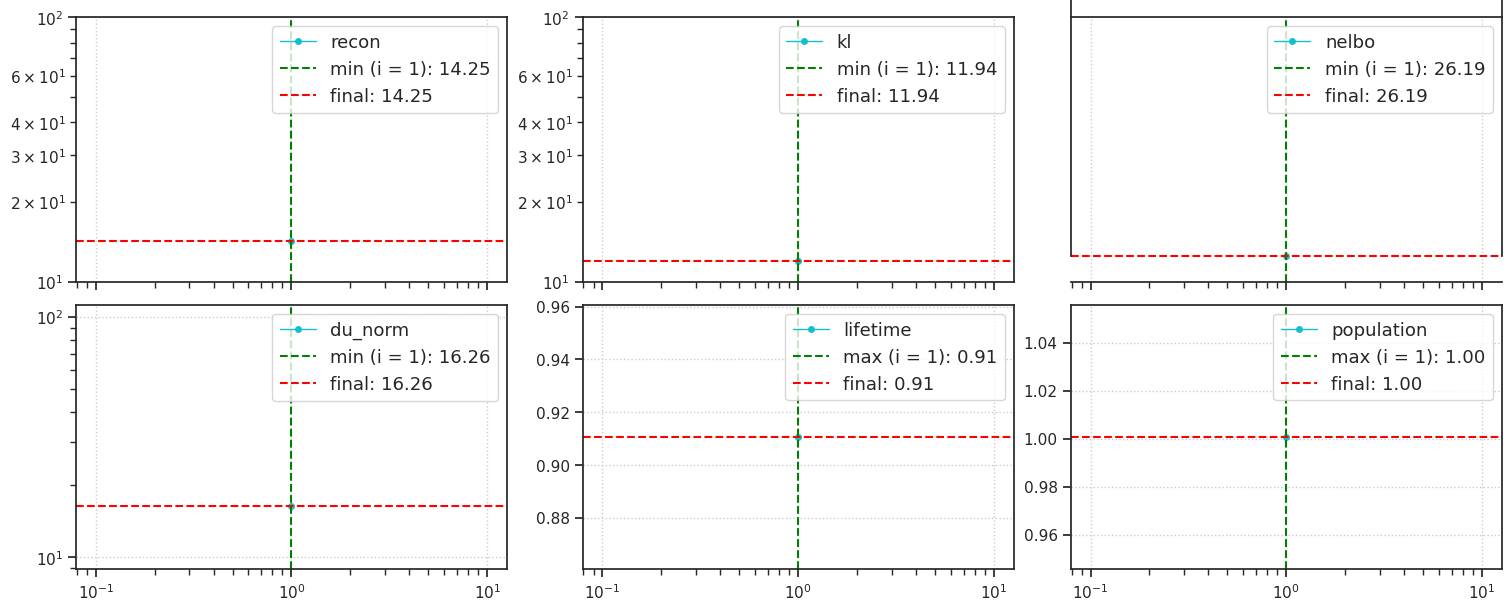

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

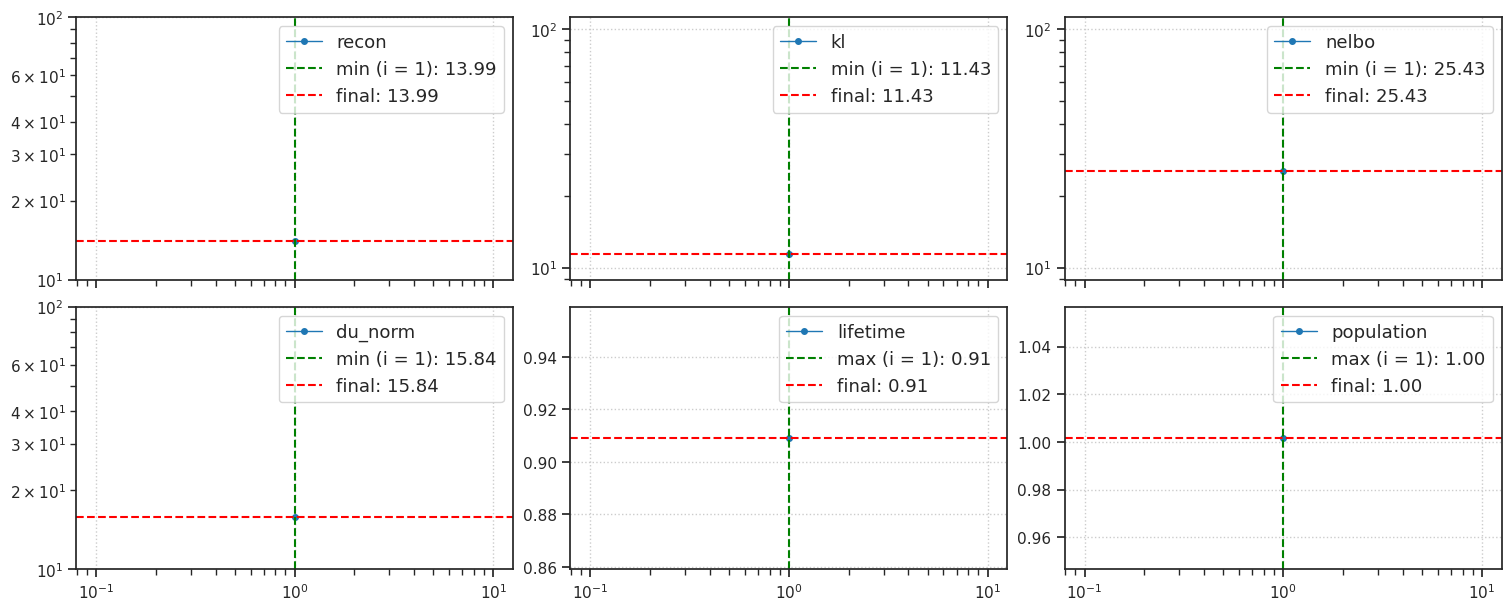

In [21]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results_to_plot.items():
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

trn

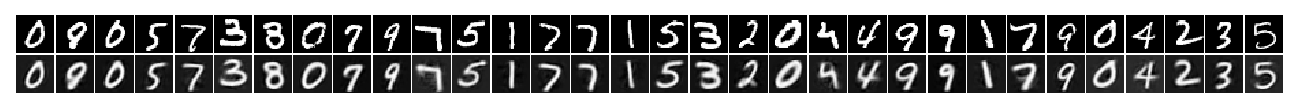

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

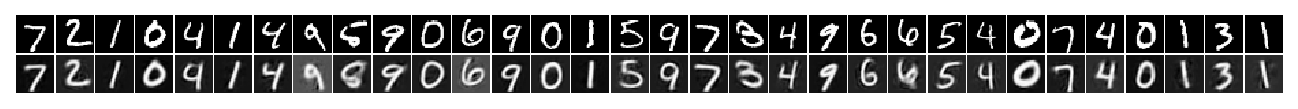

In [23]:
num = 32

for name, d in results_to_plot.items():
    print('_' * 110)
    print('-' * 110)
    print(name)
    
    x2p = np.concatenate([
        d['x'][:num],
        d['y'][:num, -1].reshape(-1, *tr.model.cfg.input_sz),
    ])
    # x2p = (x2p + 1) / 2
    _ = plot_weights(x2p, nrows=2)

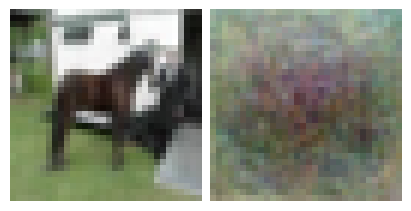

In [19]:
fig, axes = create_figure(1, 2, (4, 2))
axes[0].imshow(x2p[20].transpose(1, 2, 0))
axes[1].imshow(x2p[20+32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 264.62it/s]


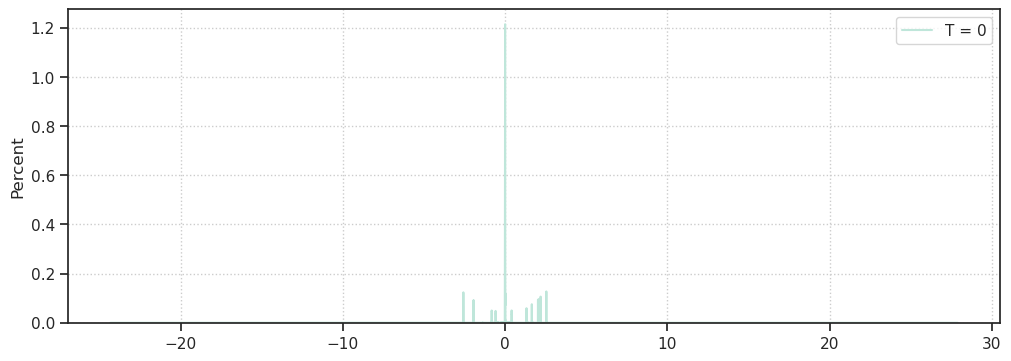

In [24]:
posterior_mus = collections.defaultdict(list)
for x, *_ in tqdm(iter(tr.dl_vld)):
    output = tr.model.xtract_ftr(x)
    for t, gaus in output['dist'].items():
        posterior_mus[t].append(gaus.loc)
posterior_mus = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_mus.items()
}


pal = sns.cubehelix_palette(
    n_colors=tr.model.cfg.seq_len,
    start=1.5,
    rot=0.3,
    gamma=1.0,
    hue=0.9,
    light=0.85,
    dark=0.15,
    reverse=False,
    as_cmap=False,
)


fig, ax = create_figure(1, 1, (10, 3.5))
for i, (t, v) in enumerate(posterior_mus.items()):
    sns.histplot(
        v.ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
ax.legend()
ax.grid()
plt.show()

### generate

In [16]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

output = tr.model.generate(pred, seq=range(300))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [17]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

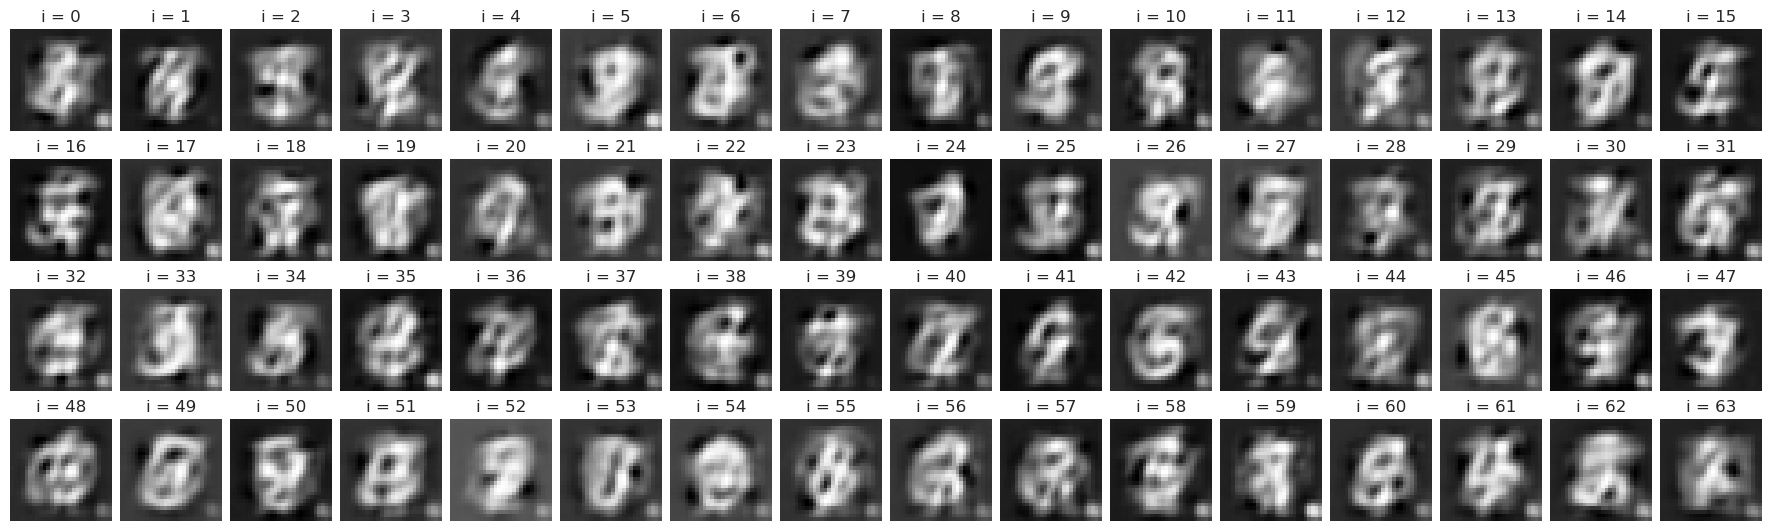

In [18]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [23]:
sample_i = 34

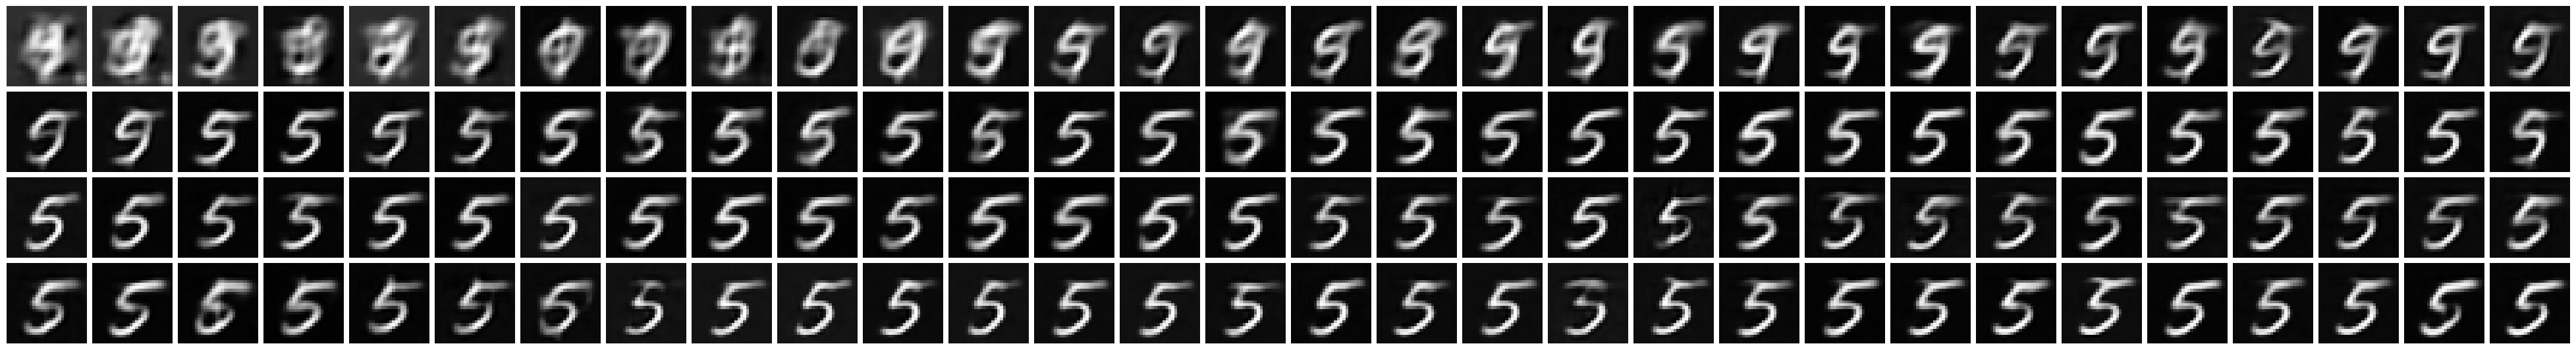

In [24]:
nrows, ncols = 4, 30
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)

In [19]:
order = np.argsort(desc_len)[::-1]

In [ ]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 2, 20
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=50)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(shape))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()